# Simulation: Dominoes Edition 

Using the dominoes Open Software library, I've done some preliminary simulations of different algorithms, and how they perform against each other. The following 



In [2]:
# necessary library
import dominoes
import matplotlib.pyplot as plt
import numpy as np

# 0. Choose your character(s)

The following variables contain an instance of the different algorithms that have been already implemented to play the game.

*remark: the **counter** as well as the **probabilistic_alphabeta** players run extremely slowly, making it harder to actually run any simulations with them*

In [10]:
# initiate instance of each type of player

player_1 = dominoes.players.random_player
q_agent = dominoes.players.QAgent()
q_agent.train(n = 1000)

bota_gorda = dominoes.players.bota_gorda


Done training


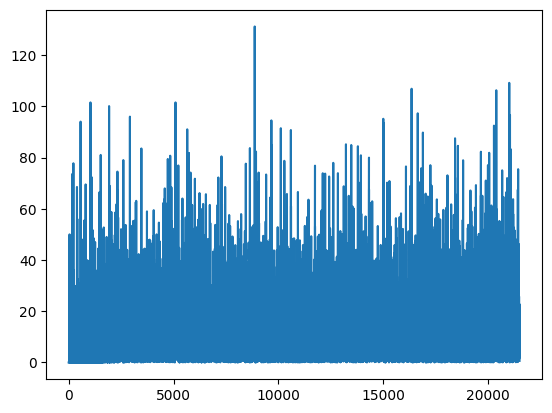

In [13]:
plt.plot(range(len(q_agent.training_error)), q_agent.training_error)

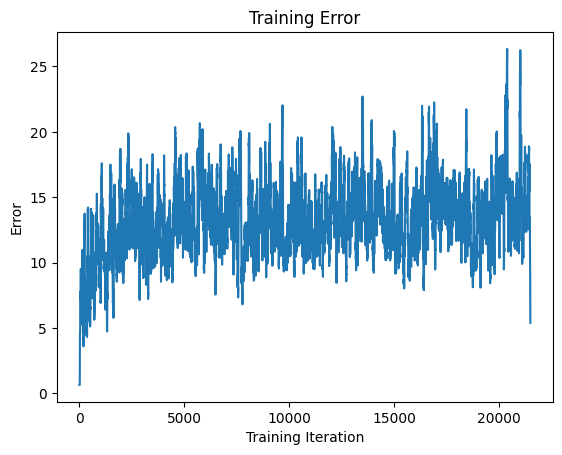

In [11]:
rolling_length = 50
# compute and assign a rolling average of the data to provide a smoother graph
training_error_moving_average = (
    np.convolve(np.array(q_agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
fig = plt.plot(range(len(training_error_moving_average)), training_error_moving_average)

# set title and labels
plt.title("Training Error")
plt.xlabel("Training Iteration")
plt.ylabel("Error")
plt.show()


we now concatante a list of 4 of the previous players. These will be used when running simulations

In [36]:
player_settings = [('AI: random', player_1),
                   ('AI: q-agent', q_agent), 
                   ('AI: random', player_1), 
                   ('AI: q-agent', q_agent)]

player_settings = [('AI: gorda', bota_gorda),
                   ('AI: q-agent', q_agent), 
                   ('AI: gorda', bota_gorda), 
                   ('AI: q-agent', q_agent)]

player_settings

[('AI: gorda', <function dominoes.players.bota_gorda(game)>),
 ('AI: q-agent', <dominoes.players.QAgent at 0x108d16700>),
 ('AI: gorda', <function dominoes.players.bota_gorda(game)>),
 ('AI: q-agent', <dominoes.players.QAgent at 0x108d16700>)]

# 1. Playing a single game of dominoes

In [17]:
def single_game(player_settings):
    """
    automatically runs a single game, with the four players specified 
    in the "player_settings" argument. 
    returns the game object of the played game.
    
    """
    
    single_game = dominoes.Game.new(starting_domino= dominoes.Domino(6,6))

    while single_game.result is None: 
            # remember whose turn it currently is.
            # we'll need it after we move on to the next player.
            turn = single_game.turn

            # get the setting for the current player
            player_setting_name, player_object = player_settings[single_game.turn]

            # the current player is an AI. apply the player setting to select a
            # move to play and make the selected move
            player_object(single_game)
            single_game.make_move(*single_game.valid_moves[0])
    
    return single_game

It can be used as follows

In [37]:
res = single_game(player_settings)
res.result

Result(player=0, won=True, points=20)

# 3. Preliminary simulations: who wins more?

the next block of code runs a certain number of iterations of the same faceoff between two teams, recording which team won (not by how much). The results are stored in a tuple. The results should be balanced

In [27]:
def simulate_games(player_settings, n = 100):
    """
    simulates n games with the four players specified in the "player_settings" argument. 
    returns a list of game objects of the played games.
    
    """
    games = []
    for i in range(n):
        games.append(single_game(player_settings).result.points)
    
    # create mask over games.points if greater than 0. then count
    # number of True values in mask
    win_count = sum([1 for i in games if i > 0])
    print("Team 0 won " + str(win_count) + " out of " + str(n) + " games.")
    return games

In [40]:
games = simulate_games(player_settings, n = 10000)
sum(games)

Team 0 won 5181 out of 10000 games.


34430

In [127]:
# player_settings = [('AI: 0', player_0), # bota gorda
#                    ('AI: 1', player_2), # random
#                    ('AI: 2', player_2), # random
#                    ('AI: 3', player_3)] # bota gorda


iters = 1000
team_0 = 0
team_0_count = 0

team_1 = 0
team_1_count = 0
for i in range(iters):
    game = single_game(player_settings)
    result = game.result
    
    # team 0 or team 1 won
    if result[0] == 0 or result[0] == 2:
        team_0 += 1
        team_0_count += result[1]
    else:
        team_1 += 1 
        team_1_count += result[1]
        
print(f"Team 0: {team_0} wins. {team_0_count} points.\n\
Team 1: {team_1} wins. {team_1_count} points.")


Team 0: 539 wins. 418 points.
Team 1: 461 wins. 304 points.


# 4. Now, lets play a series

in classical dominoes, a series of games are played up to 100 or 150 points. Hence, the first team to accumulate 150 points wins. We'll now count those. The following function `single_series`, runs a single iteration 

In [146]:
def single_series(player_settings, target_score = 150):
    """
    run a single iteration of a domino series
    arguments:
        - player_settings: list. 4 tuples containing names and types of players
        - target_score: int. winning score for a series of domino games. default is 150.
    
    returns:
        series object, containing the results and other key information.
    """

    series = dominoes.Series(target_score= target_score)
    game = series.games[0]

    while not series.is_over():

        # the player holding the [6|6] plays first, in the first game. in all other
        # games, the outcome of the previous game determines the starting player.

        # game.result will be filled in once the game ends
        while game.result is None:

            # remember whose turn it currently is.
            # we'll need it after we move on to the next player.
            turn = game.turn

            # get the setting for the current player
            player_setting_name, player_setting = player_settings[game.turn]

            # the current player is an AI. apply the player setting to select a
            # move to play. the player setting is a callable that will sort the
            # game's valid moves in decreasing order of preference.
            player_setting(game)


            # make the selected move
            game.make_move(*game.valid_moves[0])

        # go to next game in series 
        game = series.next_game()
    
    return series

one can now use that logic to instantly simulate a domino series, for example:


In [ ]:
res = single_series(player_settings)
res

---
Now, we're ready to run hundreds of domino series simulations and compare the performance of different agents. This is the true KPI for dominoes.

In [ ]:
# simulation parameters
iters = 2
target_score = 150
player_settings = [('AI: 0', player_2),
                   ('AI: 1', player_2), # prefers to play doubles 
                   ('AI: 2', player_2), 
                   ('AI: 3', player_2)] # all random

# initialize counters
team_0, team_1 = 0 , 0
team_0_count, team_1_count = 0, 0

# run iters and store results in counter
for i in range(iters):
    series_res = single_series(player_settings, target_score = target_score)
    
    if series_res.scores[0] >= target_score:
        team_0 += 1
    else:
        team_1 += 1
        
    team_0_count += series_res.scores[0]
    team_1_count += series_res.scores[1]
        
        
# display results      
print(f"Team 0: {team_0} series wins. {team_0_count//iters} avg points per game.\n\
Team 1: {team_1} series wins. {team_1_count//iters} avg points per game.")


# Conclusions

even slight departures from randomness, like playing doubles/ playing heavy dominoes lead to huge improvements in performence.
